In [2]:
import firebase_admin
from firebase_admin import credentials, firestore

# === STEP 1: Initialize Firebase Admin SDK ===
# Replace with the path to your Firebase service account JSON
cred = credentials.Certificate("/content/ppedetection-294a3-firebase-adminsdk-fbsvc-eb064eee18.json")  # 👈 Replace this path
firebase_admin.initialize_app(cred)

# === STEP 2: Connect to Firestore ===
db = firestore.client()

# === STEP 3: Fetch Document from PPE_IMAGES Collection ===
collection_name = "PPE_IMAGES"
document_id = "qUmXjlHbI3p77DbF2eUi"  # 👈 Ensure this matches exactly from your screenshot

doc_ref = db.collection(collection_name).document(document_id)
doc = doc_ref.get()

# === STEP 4: Assign to encoded_string ===
if doc.exists:
    data = doc.to_dict()
    encoded_string = data.get("image_b64", None)
    if encoded_string:
        print("✅ Base64 image fetched successfully.")
    else:
        print("⚠️ 'image_b64' field is missing in the document.")
else:
    print(f"❌ Document with ID '{document_id}' not found in '{collection_name}'.")


✅ Base64 image fetched successfully.


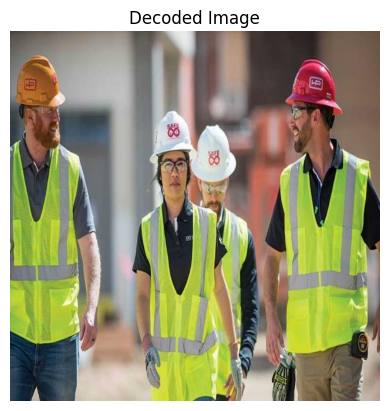

In [4]:
import base64
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Step 1: Decode the Base64 string back to bytes
decoded_bytes = base64.b64decode(encoded_string)

# Step 2: Convert bytes to NumPy array
nparr = np.frombuffer(decoded_bytes, np.uint8)

# Step 3: Decode image from the array
decoded_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Step 4: Convert BGR (OpenCV default) to RGB (matplotlib expects RGB)
decoded_image_rgb = cv2.cvtColor(decoded_image, cv2.COLOR_BGR2RGB)

# Step 5: Display the image using matplotlib
plt.imshow(decoded_image_rgb)
plt.axis('off')
plt.title("Decoded Image")
plt.show()


In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [7]:
from ultralytics import YOLO
import cv2
import numpy as np
import uuid

# === Step 6: Save the image temporarily ===
image_filename = f"ppe_input_{uuid.uuid4().hex[:8]}.jpg"
cv2.imwrite(image_filename, decoded_image)
print(f"✅ Saved decoded image as {image_filename}")

# === Step 7: Load your trained model ===
model = YOLO("/content/best.pt")  # 🔁 Make sure this path points to your model file

# === Step 8: Run inference ===
results = model.predict(source=image_filename, conf=0.25)

# === Step 9: Calculate PPE score ===
# We'll define PPE Score as the ratio of PPE-compliant detections to total detections
# Classes 0-4 are PPE, 5-9 are non-compliant
ppe_classes = [0, 1, 2, 3, 4]
total_detections = 0
ppe_detections = 0

for result in results:
    for box in result.boxes:
        cls_id = int(box.cls[0])
        total_detections += 1
        if cls_id in ppe_classes:
            ppe_detections += 1

ppe_score = round(ppe_detections / total_detections, 2) if total_detections > 0 else 0.0

print(f"🎯 PPE Score: {ppe_score}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Saved decoded image as ppe_input_6fbd76e2.jpg

image 1/1 /content/ppe_input_6fbd76e2.jpg: 640x640 1 glove, 4 helmets, 4 hse_glassess, 3 hse_vests, 8 no_gloves, 2016.7ms
Speed: 11.7ms preprocess, 2016.7ms inference, 42.2ms postprocess per image at shape (1, 3, 640, 640)
🎯 PPE Score: 0.6


In [8]:
print(results)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'glove', 1: 'helmet', 2: 'hse_boot', 3: 'hse_glasses', 4: 'hse_vest', 5: 'no_glove', 6: 'no_helmet', 7: 'no_hse_boot', 8: 'no_hse_glasses', 9: 'no_hse_vest'}
obb: None
orig_img: array([[[ 59,  66,  69],
        [ 59,  66,  69],
        [ 60,  67,  70],
        ...,
        [ 65,  80,  99],
        [ 65,  80,  99],
        [ 65,  80,  99]],

       [[ 59,  66,  69],
        [ 59,  66,  69],
        [ 60,  67,  70],
        ...,
        [ 65,  80,  99],
        [ 65,  80,  99],
        [ 65,  80,  99]],

       [[ 60,  67,  70],
        [ 60,  67,  70],
        [ 61,  68,  71],
        ...,
        [ 66,  81, 100],
        [ 66,  81, 100],
        [ 66,  81, 100]],

       ...,

       [[ 90,  67,  41],
        [ 89,  66,  40],
        [ 87,  64,  38],
        ...,
        [151, 161, 185],
        [151, 161, 185],
        [151, 161, 185]],

  

In [10]:
# Assuming your model prediction is already done
results = model.predict("/content/ppe_input_6fbd76e2.jpg", conf=0.25)
boxes = results[0].boxes

# Step 1: Get predicted class IDs as list
pred_classes = boxes.cls.tolist()  # These are float class IDs like 0.0, 5.0 etc.

# Step 2: Define compliant (PPE) and violation classes
ppe_classes = [0, 1, 2, 3, 4]  # glove, helmet, hse_boot, hse_glasses, hse_vest
violation_classes = [5, 6, 7, 8, 9]  # no_glove, no_helmet, etc.

# Step 3: Count PPE-compliant detections
ppe_detections = sum(1 for cls_id in pred_classes if int(cls_id) in ppe_classes)
total_detections = len(pred_classes)

# Step 4: Calculate PPE Score
ppe_score = ppe_detections / total_detections if total_detections > 0 else 0.0

print(f"PPE Score: {ppe_score:.2f}")



image 1/1 /content/ppe_input_6fbd76e2.jpg: 640x640 1 glove, 4 helmets, 4 hse_glassess, 3 hse_vests, 8 no_gloves, 2246.6ms
Speed: 4.1ms preprocess, 2246.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
PPE Score: 0.60


In [11]:
import firebase_admin
from firebase_admin import credentials, firestore

# Initialize Firestore (run only once per session)
if not firebase_admin._apps:
    cred = credentials.Certificate("/content/your-firebase-adminsdk-key.json")  # Replace with your key path
    firebase_admin.initialize_app(cred)

# Get Firestore client
db = firestore.client()

# Reference the correct document in PPE_IMAGES
doc_ref = db.collection("PPE_IMAGES").document("qUmXjlHbI3p77DbF2eUi")

# Update the ppe_score field
doc_ref.update({
    "ppe_score": round(ppe_score, 2)  # round to 2 decimals for readability
})

print("✅ PPE Score successfully updated in Firestore!")


✅ PPE Score successfully updated in Firestore!
